In [12]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Configuration
image_dir = './data_images'
img_size = (128, 128)
classes = ['Pinus_pinaster', 'Eucalyptus_globulus', 'Quercus_suber']
batch_size = 16
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Custom Dataset
class TreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [15]:
# Prepare data
all_paths = []
all_labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        label = "_".join(filename.split("_")[:2])
        if label in classes:
            path = os.path.join(image_dir, filename)
            all_paths.append(path)
            all_labels.append(label)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(all_labels)

In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    all_paths, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

In [17]:
# Transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),  # Converts to [0,1] and CxHxW
])

# Dataloaders
train_dataset = TreeDataset(X_train, y_train, transform=transform)
test_dataset = TreeDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 32, 63, 63]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 64, 30, 30]
        x = x.view(-1, 64 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
# Initialize model
model = SimpleCNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training loop with accuracy tracking
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f} - Val Acc: {val_acc:.2f}")

Epoch 1/15 - Loss: 22.0037 - Train Acc: 0.30 - Val Acc: 0.38
Epoch 2/15 - Loss: 15.2320 - Train Acc: 0.40 - Val Acc: 0.36
Epoch 3/15 - Loss: 15.2382 - Train Acc: 0.39 - Val Acc: 0.43
Epoch 4/15 - Loss: 14.7760 - Train Acc: 0.43 - Val Acc: 0.49
Epoch 5/15 - Loss: 14.0487 - Train Acc: 0.51 - Val Acc: 0.53
Epoch 6/15 - Loss: 13.6977 - Train Acc: 0.49 - Val Acc: 0.49
Epoch 7/15 - Loss: 13.1491 - Train Acc: 0.51 - Val Acc: 0.53
Epoch 8/15 - Loss: 12.3661 - Train Acc: 0.58 - Val Acc: 0.51
Epoch 9/15 - Loss: 13.0365 - Train Acc: 0.61 - Val Acc: 0.51
Epoch 10/15 - Loss: 12.3575 - Train Acc: 0.66 - Val Acc: 0.47
Epoch 11/15 - Loss: 11.6750 - Train Acc: 0.62 - Val Acc: 0.57
Epoch 12/15 - Loss: 10.7439 - Train Acc: 0.61 - Val Acc: 0.53
Epoch 13/15 - Loss: 10.2950 - Train Acc: 0.68 - Val Acc: 0.49
Epoch 14/15 - Loss: 8.6213 - Train Acc: 0.75 - Val Acc: 0.55
Epoch 15/15 - Loss: 7.6574 - Train Acc: 0.78 - Val Acc: 0.47


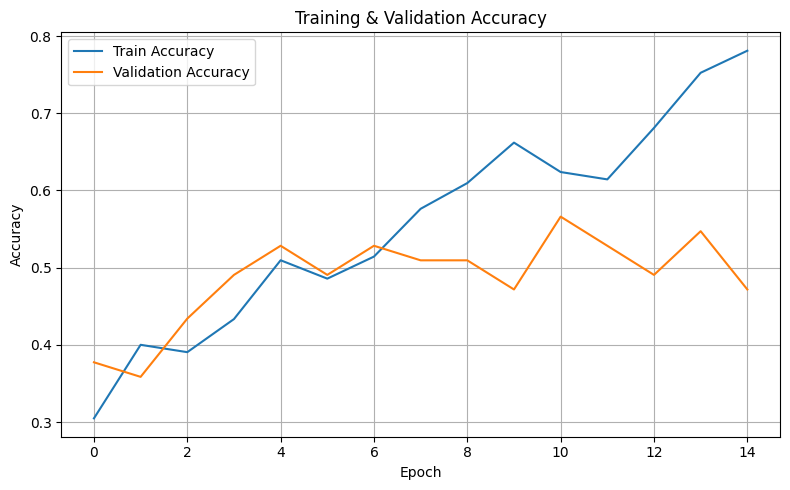

In [21]:
# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

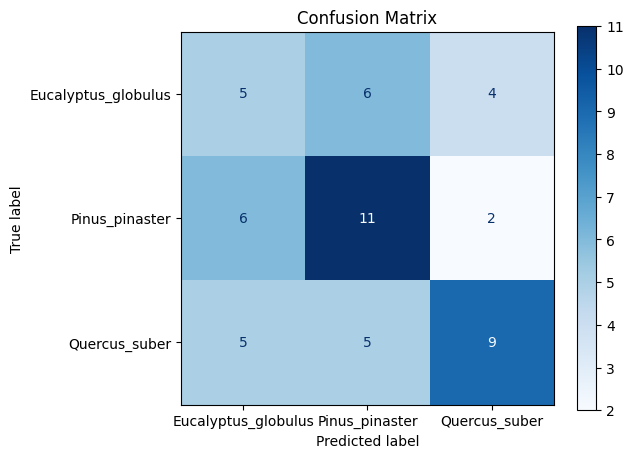

In [22]:
# Final Evaluation: Confusion Matrix
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()